In [1]:
%autoreload 2 
%matplotlib ipympl

import numpy as np 
from pianoq.misc.mplt import mplot, mimshow
from pianoq.simulations.abstract_quantum_scaling.qwfs_simulation import QWFSSimulation
from pianoq.simulations.abstract_quantum_scaling.qwfs_result import QWFSResult
from pianoq.misc.mplc_writeup_imports import *
from pianoq.simulations.abstract_quantum_scaling.qwfs_utils import get_slm3_intensities, get_slm1_intensities, show_tot_energy_at_planes, show_I_out_I_middle, get_output_random_phases, show_hist_intensities, show_max_norm_Ts, show_effics, get_res_phases, show_max_SVD_N_dependance_numeric, show_max_SVD_N_dependance_pseudo_analytic

# We trust the optimization works well for relevant dimensions
We run the BFGS optimization algorithms on the different configurations, and it seems to be working well, so we beleive its results also in the context of SLM3. 

Here N_modes=256 

In [69]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_11_26_16_55_09_qwfs_long_with_analytic.npz"
res = QWFSResult(path)

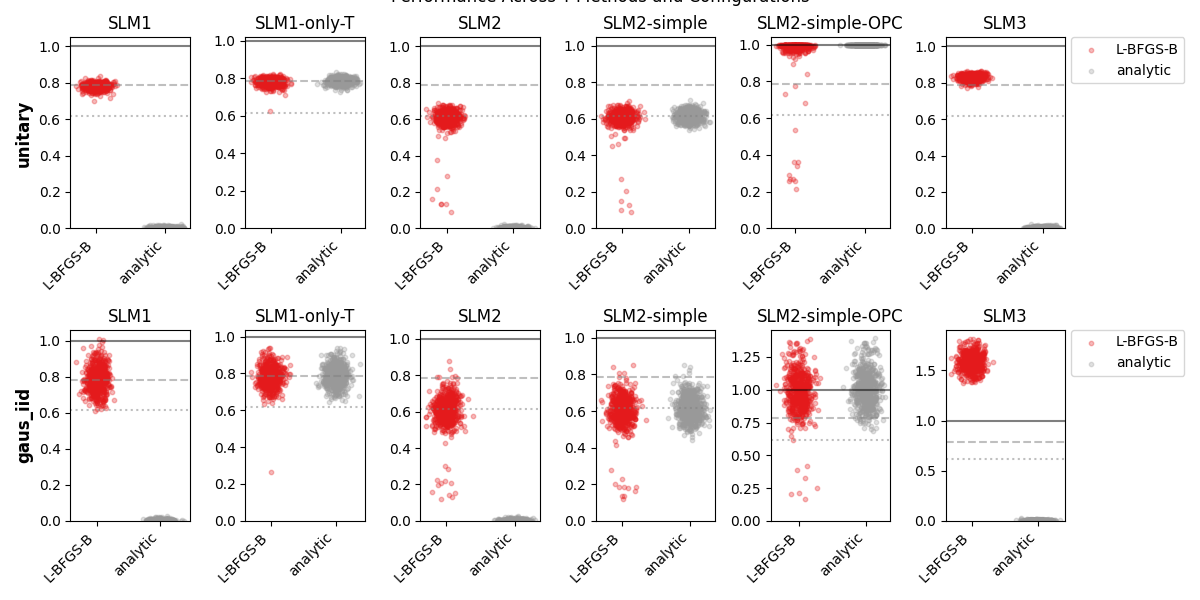

In [3]:
res.show_scatterplots()
plt.show(block=False)

In [171]:
res.print()
print(f'{res.N_modes=}')
print(f'{res.N_tries=}')

---- SLM3 ----
-- unitary --
L-BFGS-B                  0.827+-0.02
-- gaus_iid --
L-BFGS-B                  1.556+-0.08

---- SLM3-same-mode ----
-- unitary --
L-BFGS-B                  0.999+-0.00
-- gaus_iid --
L-BFGS-B                  3.769+-0.22

res.N_modes=256
res.N_tries=array(50)


## conclusions: 
And it seems that the simulation is all more or less OK:
* For SLM1 with and without the FFT etc. we get the $\pi / 4$, both analytically and with the nonlinear search. 
* Same for SLM2 configuration, and for OPC. 
* In both cases the spread of results is wider with the Gaussian IID than with unitary matrices, but this is expected. 
* The nonlinear search sometimes fails. 
* SLM3 is indeed $0.83 > \pi / 4$ for unitary, and $\approx 1.5$ for Gaussian IID, which is interesting! 

So basically now I can forget about all the SLM1,SLM2,OPC, since they all work and make sense, and only need to think better about the SLM3 configuration, why we get more than $\pi/4$ and why we get $1.5$! These are two questions with probably pretty different answers. The 0.83 might be the result of some mathematical reasoning. The 1.5 has something to do with energy harvesting somehow. We should look at the intensity distribution at different places to see what's what. 

## What solutions does BFGS find?
Aparently - it does find the same phases as the analytic solution. There are not many different solutions, even in gaus_iid
 

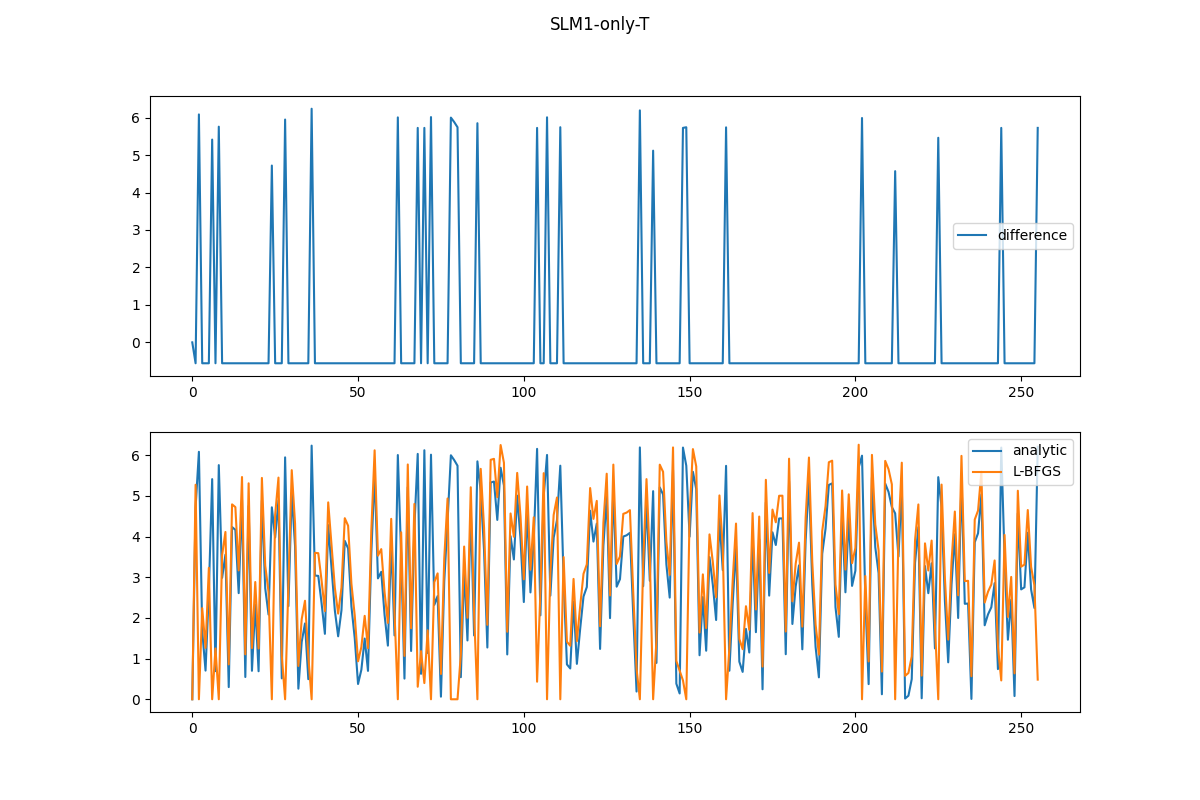

In [72]:
# config = 'SLM1-only-T'
# config = 'SLM2-simple'
config = 'SLM2-simple-OPC'
T_method = 'gaus_iid'
# T_method = 'unitary'
phases_analytic = get_res_phases(res, config=config, T_method=T_method, alg='analytic')
phases_BFGS = get_res_phases(res, config=config, T_method=T_method, alg='L-BFGS-B')

phases_analytic -= phases_analytic[:, 0][:, np.newaxis]
phases_BFGS -= phases_BFGS[:, 0][:, np.newaxis]

phases_analytic = phases_analytic % (2*np.pi)
phases_BFGS = phases_BFGS % (2*np.pi)

i = np.random.randint(phases_analytic.shape[0])

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle(config)
axes[1].plot(phases_analytic[i], label='analytic')
axes[1].plot(phases_BFGS[i], label='L-BFGS')
axes[1].legend()

axes[0].plot(phases_analytic[i] - phases_BFGS[i], label='difference')
axes[0].legend()

# understand the 1.5

## Total output intensity in crsytal and output planes 
It is interesting to look at the total intensity at the crystal plane and at the output plane. In the unitary case everything will always be 1 by definition, but what about the gaus_iid case? 

In [88]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_11_26_16_55_09_qwfs_long_with_analytic.npz"
res = QWFSResult(path)

In [89]:
T_method = 'gaus_iid'
I_outs, I_middles, I_focuss = get_slm3_intensities(res, T_method=T_method)

Sample of output distribution in crystal and in output planes:

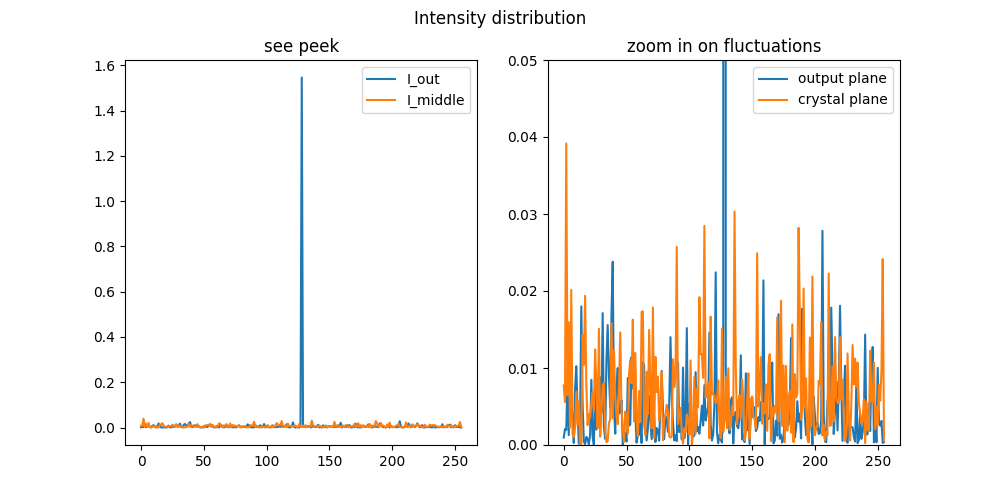

In [94]:
i = 10
show_I_out_I_middle(I_outs[i], I_middles[i])

And disribution of power at middle, at output, and of power at output / power at middle squared. 

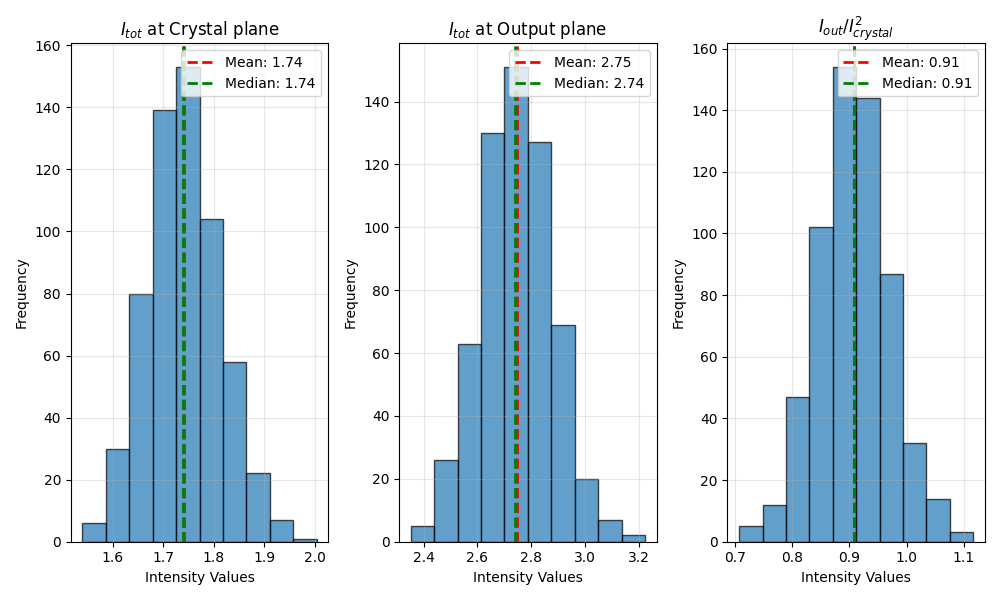

In [95]:
show_tot_energy_at_planes(I_middles, I_outs)

Interestingly, the total intensity at the crystal plane with the optimized phase is also already ~1.7! And then it grows larger to 2.75. So these phases somehow grows the intensity in both trips, which is a little bit surprising. It also seems that the "gain" of the first and second path are roughly the same, with the second pass having slightly less gain (0.9x).

But we should ask - how hard is it to get such high gain? For random phases - how much gain should I expect? In this graph we play with random phases and look at the output total intensity and see that we are several standard deviations away. (2.7 compared to ~1+-0.1) 

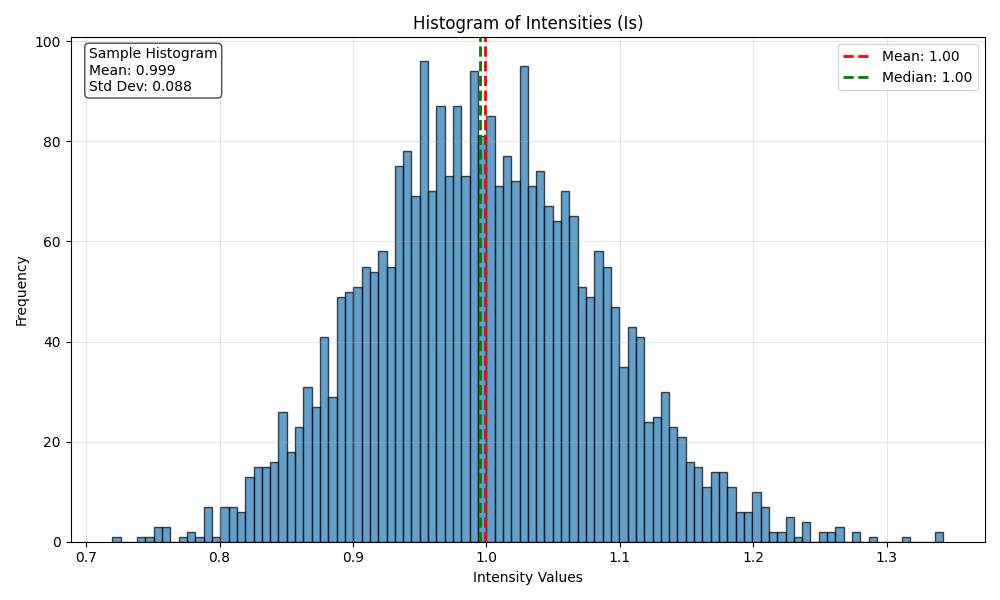

In [101]:
Is = get_output_random_phases(config='SLM3', T_method='gaus_iid', N=3000)
show_hist_intensities(Is)

Another way to look at this is to look at the norm of rows and columns of the different Ts, which we see are also ~1.25. 


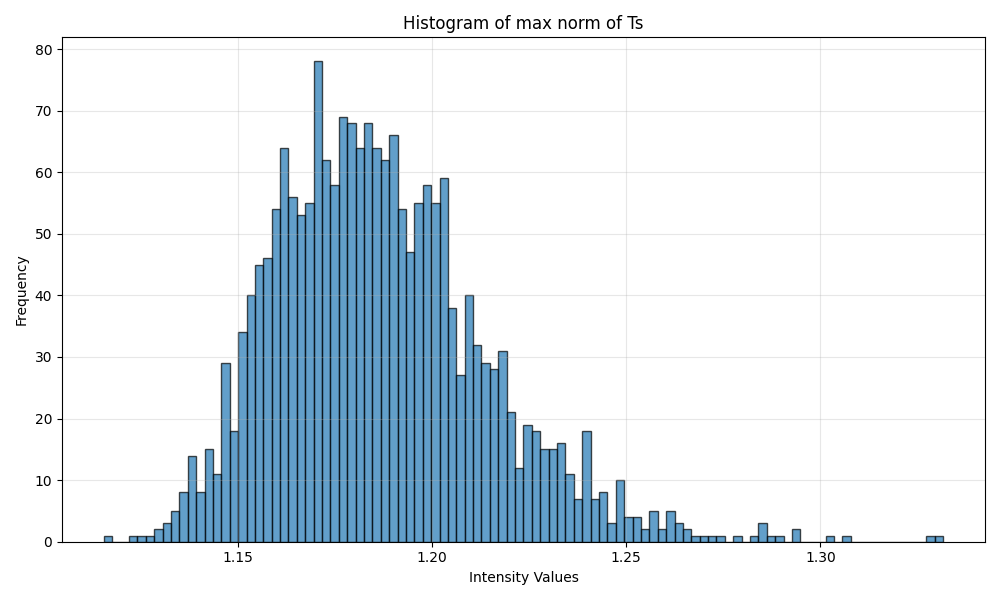

In [103]:
show_max_norm_Ts(N_modes=256, N_Ts=1000)

So we understand that we really somehow gain a significant amount of energy at the output. So how much is 1.5 comared to that? It is a great efficiency, but what is the contrast at the output? Let's plot it. (In the unitary configuration, or other configurationsit is not a relevant question, since the output power is 1... 

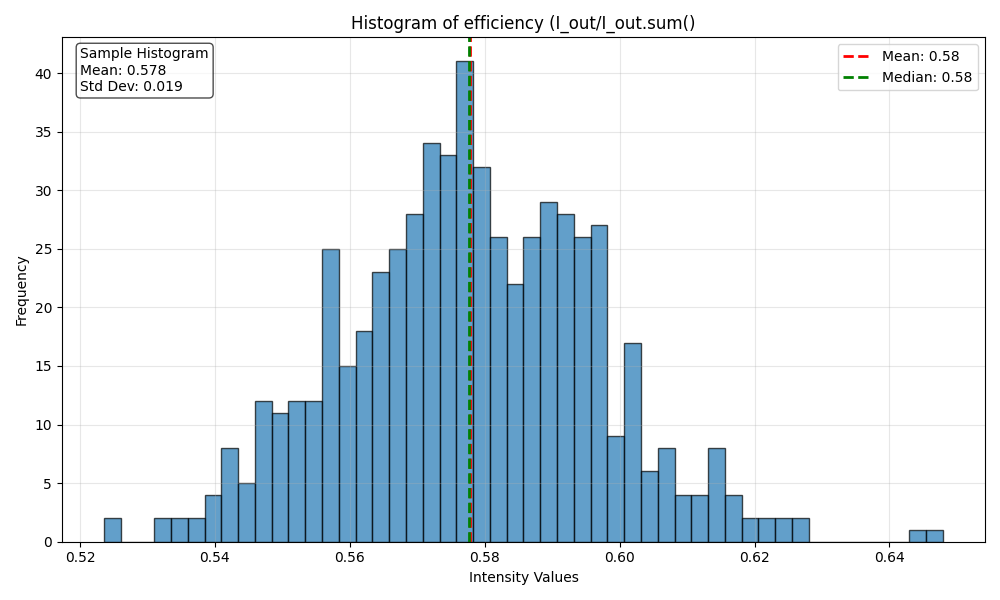

In [105]:
effics = I_focuss / I_outs.sum(axis=1)
show_effics(effics)

And we get a distribution around $0.578\pm0.02$, which is worse than SLM2! But the question now remains - here we tried to maximze intensity and got 1.6, but with low contrast. What will happen if we try to maximize the contrast? 

## Optimize contrast 

---- SLM1-only-T ----
-- unitary --
L-BFGS-B                  0.780+-0.02
analytic                  0.784+-0.02
-- gaus_iid --
L-BFGS-B                  0.329+-0.04
analytic                  0.791+-0.06

---- SLM3 ----
-- unitary --
L-BFGS-B                  0.830+-0.02
analytic                  0.004+-0.00
-- gaus_iid --
L-BFGS-B                  0.561+-0.06
analytic                  0.004+-0.00



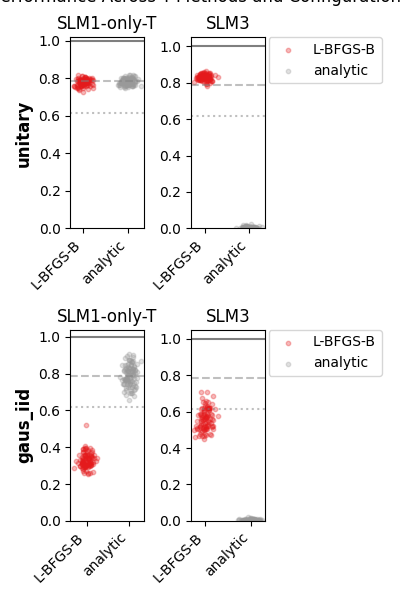

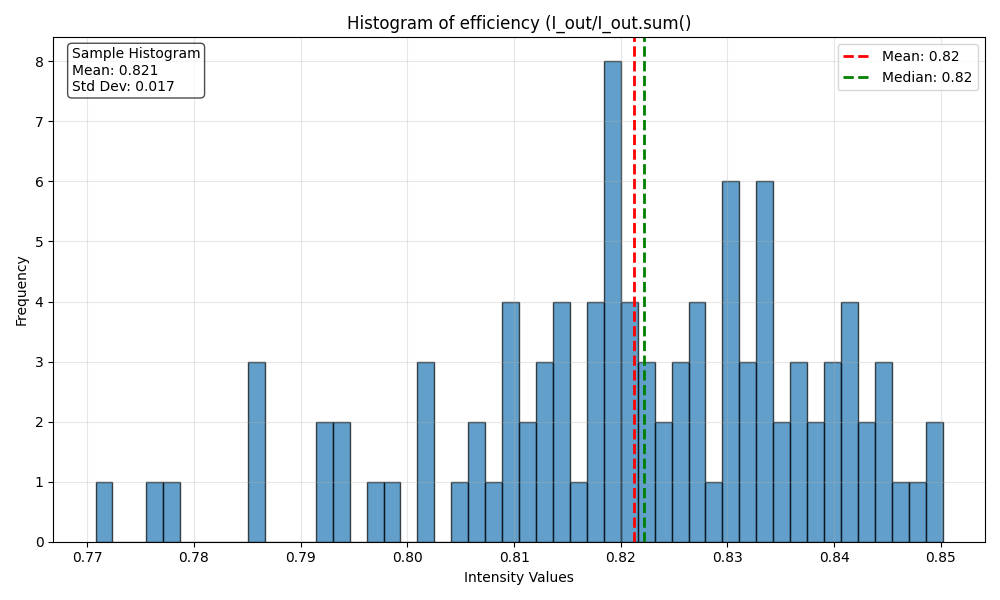

In [70]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_12_05_10_57_28_qwfs_slm3_N=256_100_tries_cost_conrast.npz"
res = QWFSResult(path=path)
I_outs, I_middles, I_focuss = get_slm3_intensities(res, T_method=T_method)
res.show_scatterplots()
res.print()
# show_I_out_I_middle(I_outs[10], I_middles[10])
# show_tot_energy_at_planes(I_middles, I_outs)
effics3 = I_focuss / I_outs.sum(axis=1)
show_effics(effics3)

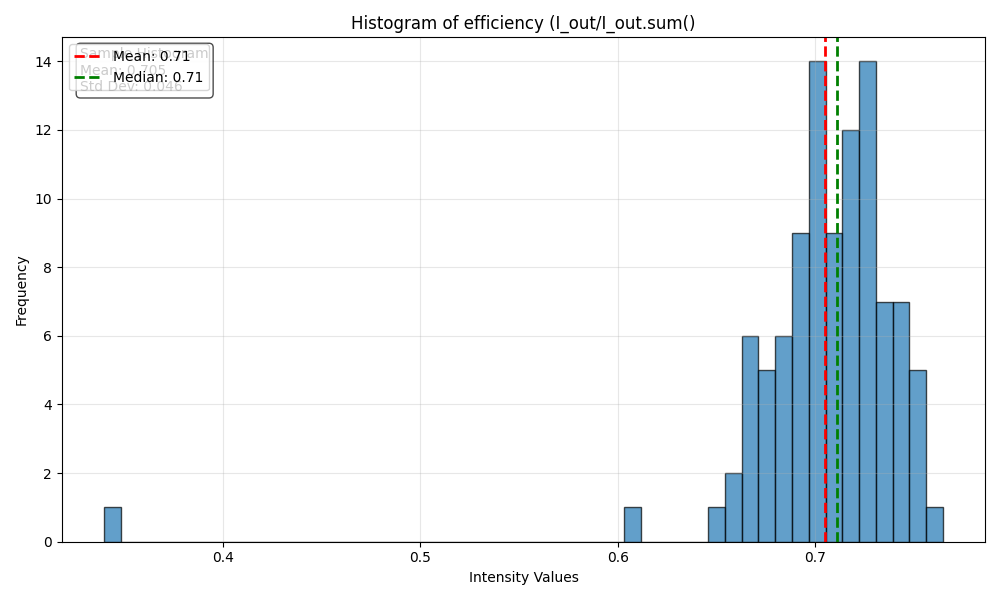

In [85]:
T_method = 'gaus_iid'
# T_method = 'unitary'
I_outs, I_focuss = get_slm1_intensities(res, T_method=T_method)
effics3 = I_focuss / I_outs.sum(axis=1)
show_effics(effics3)

It seems that when optimizing the contrast, the total intensity tends to be rather low (~0.56), but the contrast, which is what we optimized for, remains at ~0.83, which is cool! 

So what happens with the SLM1 case? in that case it seems that optimizing for contrast confuses him, and he does not get to the pi/4=0.78, but rather to 0.71. When trying to optimize intensity it he gets the optimal pi/4, but also a reasonable ~1 total output intensity, right? apparently, no! It turns out that the results above where he found the almost optimial solutions with pi/4 where actually with mean total output power of ~1.77, and the 0.78 it found was actually with "real efficiency" of only 0.44! Here is the code:

## contrast is the same story with analytic

In [104]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_11_26_16_55_09_qwfs_long_with_analytic.npz"
res = QWFSResult(path)

In [126]:
T_method = 'gaus_iid'
# T_method = 'unitary'
# I_outs, I_focuss = get_slm1_intensities(res, config='SLM1-only-T', T_method=T_method, alg='analytic')
# I_outs, I_focuss = get_slm1_intensities(res, config='SLM1-only-T', T_method=T_method, alg='L-BFGS-B')
# I_outs, I_focuss = get_slm1_intensities(res, config='SLM1', T_method=T_method, alg='L-BFGS-B')
# I_outs, I_focuss = get_slm1_intensities(res, config='SLM2', T_method=T_method, alg='L-BFGS-B')
# I_outs, I_focuss = get_slm1_intensities(res, config='SLM2-simple', T_method=T_method, alg='analytic')
# I_outs, I_focuss = get_slm1_intensities(res, config='SLM2-simple-OPC', T_method=T_method, alg='L-BFGS-B')
I_outs, I_focuss = get_slm1_intensities(res, config='SLM3', T_method=T_method, alg='L-BFGS-B')
# I_outs, I_focuss = get_slm1_intensities(res, config='SLM1', T_method=T_method)
print(f'{res.N_modes=}')
print(f'{I_outs.sum(axis=1).mean()=}')
print(f'{I_focuss.mean()=}')

# effics = I_focuss / I_outs.sum(axis=1)
# print(f'{effics.mean()=}')

res.N_modes=256
I_outs.sum(axis=1).mean()=2.7463816323454457
I_focuss.mean()=1.586351240933314


So what is the bottom line? When the matrix is unitary, everything is simple. The objective function is well behaved, and we find close to optimal results. With gaus_iid, so it becomes confusing, since we can optimize either the contrast or the total intensity. 

When optimizing intensity, so in SLM1 we have a theretical upper bound, and we reach it but in a weird way by getting lots of energy, and taking enough of it. In SLM3 we get larger than 1, but with relatively low contrast. 

If we optimize the contrast, so in SLM1 we get results with overall low energy, and also with a contrast which is sub-optimal (0.7 instead of 0.78). With SLM3 we also get closlow intensity, but the contrast is almost 0.83 which might be some bound, and is what we get with unitaries. 

This does not all quite compile together, but it is what it is... 

## Other matrix types
I tried also a "cue" unitary, which is basically sampling a unitary with the Haar measure, and ti gives the exact same results as regular unitaries. Another thing to try is to use matrices with a bimodal distribution of eigen values $P(\tau)=\frac{1}{\tau\cdot\sqrt{1-\tau}}$ like real scatterimg medium, and see if we go through the open channels. 

TODD: try it asd

In [119]:
pass

## SVD values 
The enhancment magnitude of the total power should probably be connected to the SVD values of the Gaussian IID matrices. So let's check what they are. 

In [148]:
N_Ts = 50
N_modes = 256
sim = QWFSSimulation(N=N_modes)
sim.T_method = 'gaus_iid'
# sim.T_method = 'unitary'
sim.reset_T()
svds_T = []
svds_TTT = []  # T@T.T
for i in range(N_Ts):
    sim.reset_T()
    u, s, v = scipy.linalg.svd(sim.T)
    svds_T.append(s)
    u, s, v = scipy.linalg.svd(sim.T@sim.T.T)
    svds_TTT.append(s)
svds_T = np.array(svds_T)
svds_TTT = np.array(svds_TTT)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'SVDs of T@T.T, N_modes=256'}>)

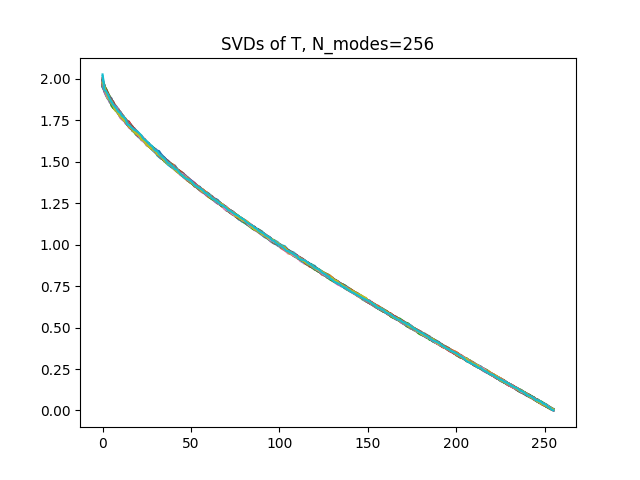

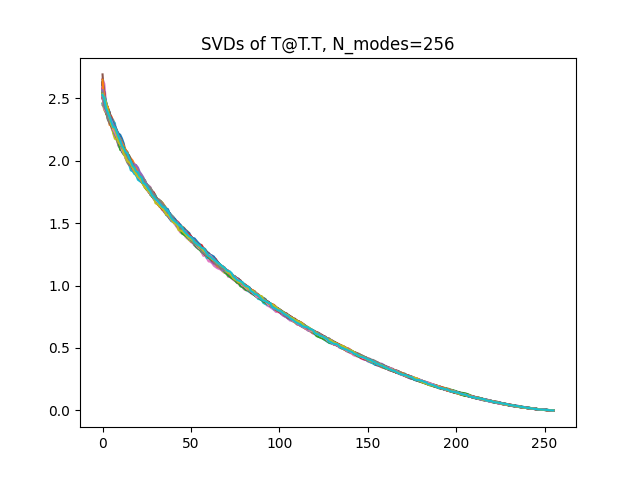

In [155]:
mplot(svds_T.T, title=f'SVDs of T, {N_modes=}', figshow=False)
mplot(svds_TTT.T, title=f'SVDs of T@T.T, {N_modes=}', figshow=False)

So there does seem to be on average SVDs of T with values > 1.7, though I am not completely sure what sets this expectation value. 

## Vary N_modes

I tried to see how these results vary with the dimension of the matrix. I also checked wether a different kind of random unitary creation will make a difference. As I expected - it didn't. But the dependence on N seems small, but existent. 

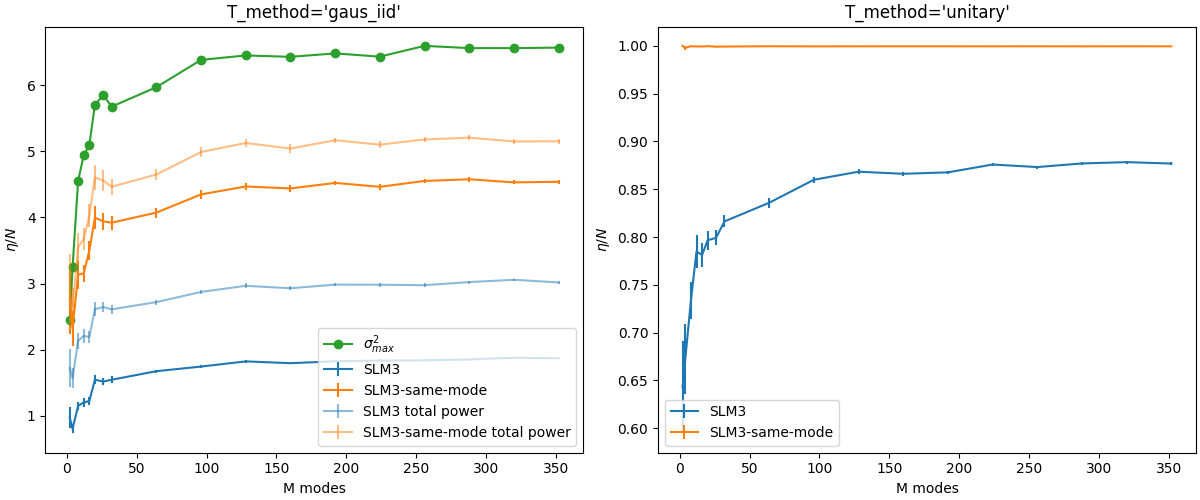

In [69]:
plt.close('all')
import re 
def get_Ns_ress(glob_regex):
    paths = glob.glob(glob_regex)
    ress = [QWFSResult(path) for path in paths]
    Ns = np.array([re.findall('.*N=(\d+)_.*', path)[0] for path in paths]).astype(float)
    Ns, ress = list(zip(*sorted(zip(Ns, ress), key=lambda pair: pair[0])))
    return np.array(Ns), np.array(ress)

def show_N_dependance(Ns, ress, which_config='SLM3', which_optimization='L-BFGS-B', full_std=False, show_SVDs=True, ylim=None):
    T_methods = ress[0].T_methods
    fig, ax = plt.subplots()
    
    for T_method_no, T_method in enumerate(T_methods):
        tot_powers = np.zeros_like(Ns)
        effs = np.zeros_like(Ns)
        eff_stds = np.zeros_like(Ns)
        max_SVDs = np.zeros_like(Ns)
        
        for i, N in enumerate(Ns):
            res = ress[i]
            # config_no = list(res.configs).index(which_config)
            # algo_no = list(res.algos).index(which_optimization)
            # effs[i] = res.results[T_method_no, config_no].mean(axis=0)[algo_no]
            # eff_stds[i] = res.results[T_method_no, config_no].std(axis=0)[algo_no]
            
            I_outs, I_focuses = get_slm1_intensities(res, config=which_config, T_method=T_method, alg=which_optimization)
            effs[i] = I_focuses.mean()
            eff_stds[i] = I_focuses.std()
            tot_powers[i] = I_outs.sum(axis=1).mean()
            
            these_Ts = res.Ts[T_method_no::2]
            if show_SVDs:
                max_SVDs[i] = np.array([np.linalg.svd(T@T.transpose(), compute_uv=False).max() for T in these_Ts]).mean()**2 # mean of max_svd^2 

        
        y_err = eff_stds
        if not full_std:
            y_err /= np.sqrt(res.results.shape[2])
        ax.errorbar(Ns, effs, yerr=y_err, label=T_method, marker='o')
        ax.plot(Ns, tot_powers, label=f'{T_method}-tot power', marker='o')
        if show_SVDs:
            ax.plot(Ns, max_SVDs, label=f'{T_method}-max-SVD', marker='o')
        # ax.errorbar(Ns, effs, yerr=eff_stds2, alpha=0.7, marker='o')
        
    if which_config in ['SLM1', 'SLM1-only-T']:
        Ns = np.linspace(Ns.min(), Ns.max(), 1000)
        theory = 1/Ns * (1 + (Ns-1)*np.pi/4)
        ax.plot(Ns, theory, linestyle='dashed', label='Theory SLM1')
    elif which_config in ['SLM2', 'SLM2-simple']:
        Ns = np.linspace(Ns.min(), Ns.max(), 1000)
        theory = 1/Ns * (1 + (Ns-1)*(np.pi/4)**2)
        ax.plot(Ns, theory, linestyle='dashed', label='Theory SLM2')
        
    if ylim:
        ax.set_ylim(ylim)
    
    ax.legend()    
    ax.set_xlabel('N_modes')
    ax.set_ylabel('Intensity')
    ax.set_title(f'{which_optimization=}, {which_config=}')
    
def figs1(Ns, ress):
    fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 5))
    
    for ax, T_method in zip(axes, ress[0].T_methods[::-1]):
        effs_SLM3 = np.zeros_like(Ns)
        stds_SLM3 = np.zeros_like(Ns)
        tot_I_outs_SLM3 = np.zeros_like(Ns)
        tot_I_outs_std_SLM3 = np.zeros_like(Ns)
        effs_SLM3_OPC = np.zeros_like(Ns)
        stds_SLM3_OPC = np.zeros_like(Ns)
        tot_I_outs_SLM3_OPC = np.zeros_like(Ns)
        tot_I_outs_std_SLM3_OPC = np.zeros_like(Ns)
        max_SVDs = np.zeros_like(Ns)

        alg_ind = np.where(ress[0].algos == 'autograd')[0]
        T_method_ind = np.where(ress[0].T_methods == T_method)[0]
    
        for i, N in enumerate(Ns):
            res = ress[i]
            
            # effs = res.results[T_method_ind, np.where(res.configs == 'SLM3')[0], :, alg_ind].squeeze()
            tot_I_outs, effs = get_slm1_intensities(res, config='SLM3', T_method=T_method, alg='autograd')
            effs_SLM3[i] = effs.mean(); stds_SLM3[i] = effs.std() / np.sqrt(res.results.shape[2])
            tot_I_outs_SLM3[i] = tot_I_outs.sum(axis=1).mean(); tot_I_outs_std_SLM3[i] = tot_I_outs.sum(axis=1).std() / np.sqrt(res.results.shape[2])
    
            # effs = res.results[T_method_ind, np.where(res.configs == 'SLM3-same-mode')[0], :, alg_ind].squeeze()
            tot_I_outs, effs = get_slm1_intensities(res, config='SLM3-same-mode', T_method=T_method, alg='autograd')
            effs_SLM3_OPC[i] = effs.mean(); stds_SLM3_OPC[i] = effs.std() / np.sqrt(res.results.shape[2])
            tot_I_outs_SLM3_OPC[i] = tot_I_outs.sum(axis=1).mean(); tot_I_outs_std_SLM3_OPC[i] = tot_I_outs.sum(axis=1).std() / np.sqrt(res.results.shape[2])

            if T_method == 'gaus_iid':
                T_method_no = np.where(ress[0].T_methods == 'gaus_iid')[0][0]
                these_Ts = res.Ts[T_method_no::2]
                max_SVDs[i] = np.array([np.linalg.svd(T@T.transpose(), compute_uv=False).max() for T in these_Ts]).mean()**2 # mean of max_svd^2
                
        lines = ax.errorbar(Ns, effs_SLM3, stds_SLM3, label='SLM3')
        lines_OPC = ax.errorbar(Ns, effs_SLM3_OPC, stds_SLM3_OPC, label='SLM3-same-mode')
        if T_method == 'gaus_iid':
            ax.plot(Ns, max_SVDs, label=r'$\sigma_{max}^2$', marker='o')
            ax.errorbar(Ns, tot_I_outs_SLM3, tot_I_outs_std_SLM3, label='SLM3 total power', color=lines[0].get_c(), alpha=0.5)
            ax.errorbar(Ns, tot_I_outs_SLM3_OPC, tot_I_outs_std_SLM3_OPC, label='SLM3-same-mode total power', color=lines_OPC[0].get_c(), alpha=0.5)

        ax.legend()
        ax.set_xlabel('N modes')
        ax.set_ylabel('$\eta/N$')
        ax.set_title(f'{T_method=}') 
        
        # ax.axhline(y=np.pi/4, color='gray', linestyle='--', alpha=0.5)
        # ax.axhline(y=(np.pi / 4) ** 2, color='gray', linestyle=':', alpha=0.5)
        # ax.axhline(y=1, color='black', linestyle='-', alpha=0.5)
        
    fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\N_dependence.png")

figs1(Ns, ress)

In [47]:
# glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_11_28_14*N=*.npz'
# glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_11_28_15*N=*.npz'
# glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_1*N=*300_tries*weekend*.npz'
glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_12_24*_N_dep_N=*30_tries.npz'
Ns, ress = get_Ns_ress(glob_regex)

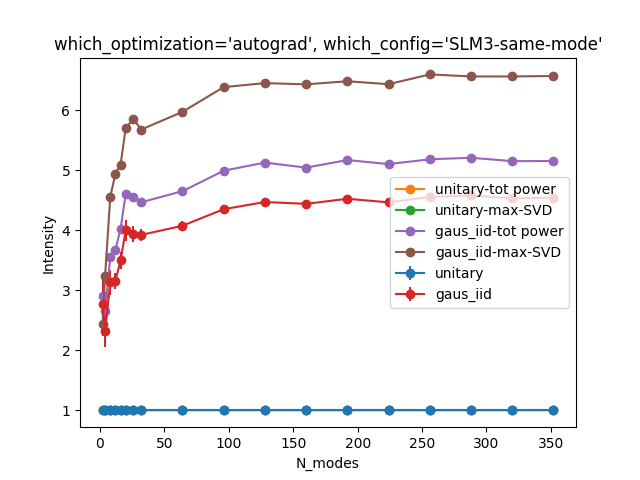

In [44]:
full_std = False
# which_optimization = 'L-BFGS-B'
which_optimization = 'autograd'
# which_optimization = 'analytic'
# which_config = 'SLM3'
which_config = 'SLM3-same-mode'
# which_config = 'SLM1-only-T'
# which_config = 'SLM2-simple'
# which_config = 'SLM2-simple-OPC'
show_N_dependance(Ns, ress, which_config=which_config, which_optimization=which_optimization, full_std=False)

And it seems that for SLM1 there is indeed a very slight N dependence due to $\eta=\frac{1}{N} + \frac{\pi}{4}\cdot\frac{N-1}{N}$, and it works pretty well. But for SLM3 we have a larger dependance, which is surprising. For large N values the down trend is probably due to the optimization not able to optimize the best. But it is not clear why it goes up with $N$. 

This might be explained using the fact that the maximal svd value is bounded by 4, and on average grows with similar scale as the efficiency. This is assuming Marchenko-Pastur and integrating numerically things. 

N=2.0, E[max_s]=1.540380
N=4.0, E[max_s]=2.130698
N=8.0, E[max_s]=2.669488
N=16.0, E[max_s]=3.096769
N=32.0, E[max_s]=3.405180
N=64.0, E[max_s]=3.615387
N=128.0, E[max_s]=3.753963
N=256.0, E[max_s]=3.843592


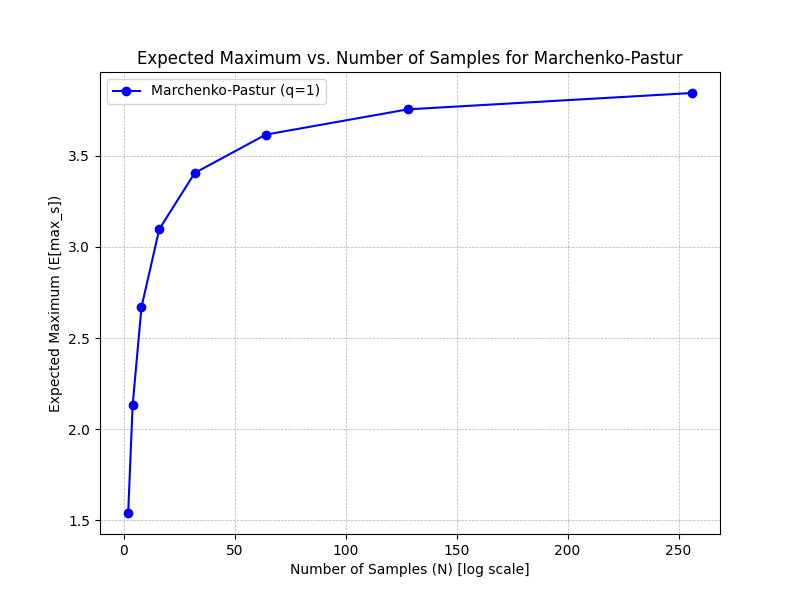

In [89]:
show_max_SVD_N_dependance_pseudo_analytic(max_power=8)

And this is with actually simmulating my kind of matrices:

N=2, sqr_mean=2.886, sqr_std=3.405, sqr_max=18.519
N=4, sqr_mean=3.781, sqr_std=2.416, sqr_max=14.618
N=8, sqr_mean=4.848, sqr_std=2.117, sqr_max=14.190
N=16, sqr_mean=5.518, sqr_std=1.424, sqr_max=12.015
N=32, sqr_mean=5.882, sqr_std=0.769, sqr_max=8.160
N=64, sqr_mean=6.218, sqr_std=0.601, sqr_max=8.477
N=128, sqr_mean=6.364, sqr_std=0.345, sqr_max=7.679
N=256, sqr_mean=6.543, sqr_std=0.232, sqr_max=7.264


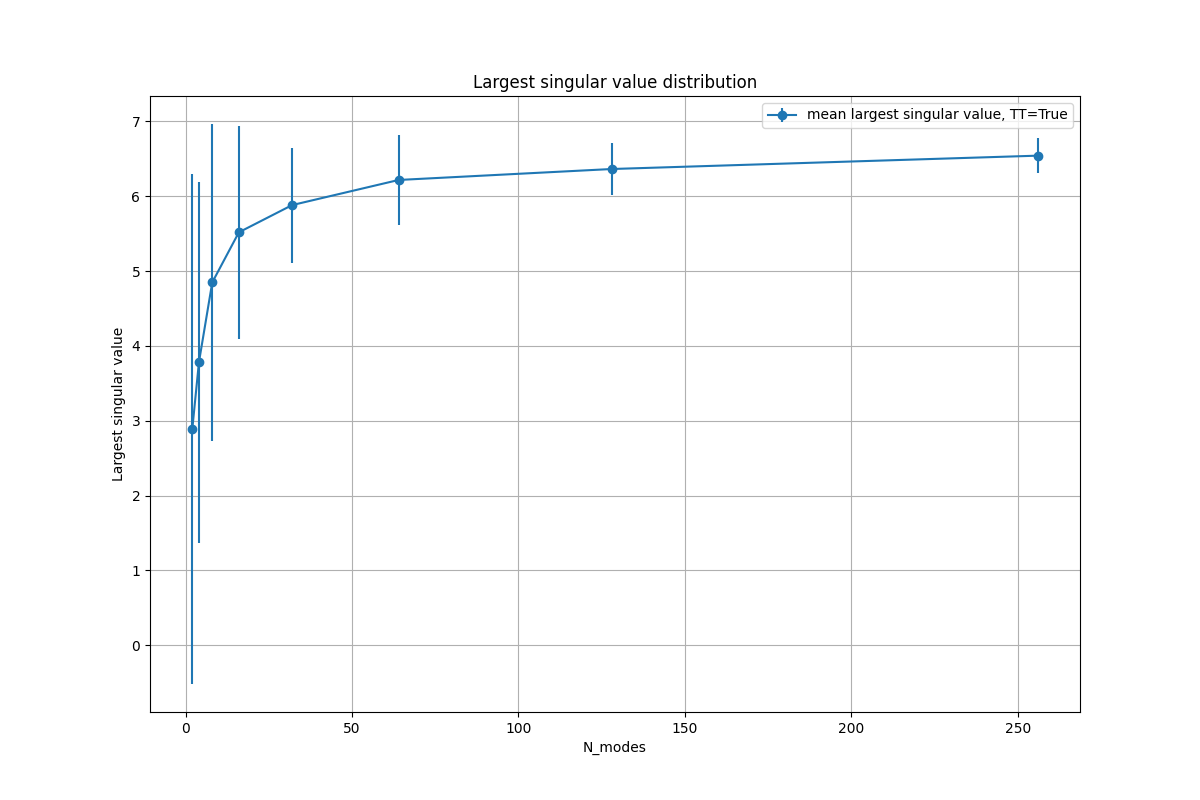

In [76]:
show_max_SVD_N_dependance_numeric(num_sample=300, max_power=8, TT=True, show_histogram=True, show_means=False)
# show_max_SVD_N_dependance_numeric(max_power=8, TT=True, show_histogram=False, show_means=True)
# show_max_SVD_N_dependance_numeric(max_power=8, TT=False)

In [ ]:
full_std = False
which_optimization = 'L-BFGS-B'
# which_optimization = 'analytic'
which_config = 'SLM3'
# which_config = 'SLM1-only-T'
# which_config = 'SLM2-simple'
# which_config = 'SLM2-simple-OPC'
show_N_dependance(Ns, ress, which_config=which_config, which_optimization=which_optimization, full_std=False)


In [40]:
for res in ress:
    print(f'---{res.N_modes=}---')
    # res.show_scatterplots()
    # plt.show(block=False)
    res.print(only_slm3=True)

50

In [102]:
ress[0].Ts[3].real.std()

0.12201505813802402

## Varry sigma in gaus_iid
In hindsight this is trivial, since having a larger sigma in the gaus_iid will cause the average total intensity to be larger, so it changes drastically the total output power in SLM3, but similarly in SLM1 etc. 

In [230]:
plt.close('all')
import re 
def get_sigs_ress(glob_regex):
    paths = glob.glob(glob_regex)
    ress = [QWFSResult(path) for path in paths]
    sigs = np.array([re.findall('.*sig=(\d+(\.\d+)?)_.*', path)[0][0] for path in paths]).astype(float)
    return sigs, ress

def show_sig_dependance(sigs, ress, which_config='SLM3', which_optimization='L-BFGS-B', full_std=False):
    T_methods = ress[0].T_methods
    fig, ax = plt.subplots()
    
    for T_method_no, T_method in enumerate(T_methods):
        effs = np.zeros_like(sigs)
        eff_stds = np.zeros_like(sigs)
        
        for i, sig in enumerate(sigs):
            res = ress[i]
            config_no = list(res.configs).index(which_config)
            algo_no = list(res.algos).index(which_optimization)
            effs[i] = res.results[T_method_no, config_no].mean(axis=0)[algo_no]
            eff_stds[i] = res.results[T_method_no, config_no].std(axis=0)[algo_no]
        
        y_err = eff_stds
        if not full_std:
            y_err /= res.results.shape[2]
        ax.errorbar(sigs, effs, yerr=y_err, label=T_method, marker='o')
        # ax.errorbar(Ns, effs, yerr=eff_stds2, alpha=0.7, marker='o')
    ax.legend()    
    ax.set_xlabel('T_sig')
    ax.set_ylabel('Efficiency')

In [ ]:
# glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_11_28_16*sig=*.npz'
glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_12_02*sig=*many_configs.npz'
sigs, ress = get_sigs_ress(glob_regex)
# show_sig_dependance(sigs, ress, which_config='SLM1-only-T', full_std=True)
# show_sig_dependance(sigs, ress, which_config='SLM2-simple', full_std=True)
# show_sig_dependance(sigs, ress, which_config='SLM2-simple-OPC', full_std=True)
show_sig_dependance(sigs, ress, which_config='SLM1-only-T', full_std=True)
# ress

In [ ]:
show_sig_dependance(sigs, ress, which_config='SLM3', full_std=True)

## Vary degree of control

In [38]:
plt.close('all')
import re 
def get_N_pixs_ress(glob_regex):
    paths = glob.glob(glob_regex)
    ress = [QWFSResult(path) for path in paths]
    Ns = np.array([re.findall('.*N_pixels_(\d+).npz', path)[0] for path in paths]).astype(float)
    Ns, ress = list(zip(*sorted(zip(Ns, ress), key=lambda pair: pair[0])))
    return np.array(Ns), np.array(ress)


def show_N_pix_dependance(N_pixs, ress, which_config='SLM3', which_optimization='L-BFGS-B', full_std=False, ylim=None, show_tot_power=False, show_max_SVDs=False):
    T_methods = ress[0].T_methods
    fig, ax = plt.subplots()
    
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab10')  # Use a colormap, 'tab10' gives distinct colors
    
    for T_method_no, T_method in enumerate(T_methods):
        tot_powers = np.zeros_like(N_pixs)
        effs = np.zeros_like(N_pixs)
        eff_stds = np.zeros_like(N_pixs)
        max_SVDs = np.zeros_like(N_pixs)
        max_SVDs = np.zeros_like(N_pixs)
        
        for i, N in enumerate(N_pixs):
            res = ress[i]
            I_outs, I_focuses = get_slm1_intensities(res, config=which_config, T_method=T_method, alg=which_optimization)
            effs[i] = I_focuses.mean()
            eff_stds[i] = I_focuses.std()
            tot_powers[i] = I_outs.sum(axis=1).mean()
            these_Ts = res.Ts[T_method_no::2]
            if show_max_SVDs:
                max_SVDs[i] = np.array([np.linalg.svd(T@T.transpose(), compute_uv=False).max() for T in these_Ts]).mean()**2 # mean of max_svd^2
        
        y_err = eff_stds
        if not full_std:
            y_err /= np.sqrt(res.results.shape[2])
        
        base_color = cmap(T_method_no % 10)  # Cycle through colors in colormap
        ax.errorbar(N_pixs, effs, yerr=y_err, label=T_method, marker='o', color=base_color)
        if show_tot_power:
            # tot_power_color = [min(1, c + 0.1) for c in base_color[:3]] + [base_color[3]]  # Lighten the color
            amount = 0.2 
            tot_power_color = [(1 - amount) * c + amount for c in base_color[:3]] + [base_color[3]] 
            ax.plot(N_pixs, tot_powers, label=f'{T_method}-tot power', marker='o', linestyle='--', color=tot_power_color)
            
        if show_max_SVDs:
            amount = 0.4 
            SVD_color = [(1 - amount) * c + amount for c in base_color[:3]] + [base_color[3]] 
            ax.plot(N_pixs, max_SVDs, label=f'{T_method}-max-SVD', marker='o', linestyle='-.', color=SVD_color)
        
    ax.legend()    
    ax.set_xlabel('N_pixels')
    ax.set_ylabel('Intensity')
    ax.set_title(f'{which_optimization=}, {which_config=}')
    
def fig3(N_pixs, ress):
    DOCs = N_pixs / ress[0].N_modes
    fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 5))
    
    for ax, T_method in zip(axes, ress[0].T_methods):
        effs_SLM1 = np.zeros_like(N_pixs)
        stds_SLM1 = np.zeros_like(N_pixs)
        effs_SLM2 = np.zeros_like(N_pixs)
        stds_SLM2 = np.zeros_like(N_pixs)
        effs_SLM2_OPC = np.zeros_like(N_pixs)
        stds_SLM2_OPC = np.zeros_like(N_pixs)
        effs_SLM3 = np.zeros_like(N_pixs)
        stds_SLM3 = np.zeros_like(N_pixs)
        effs_SLM3_OPC = np.zeros_like(N_pixs)
        stds_SLM3_OPC = np.zeros_like(N_pixs)
        alg_ind = np.where(ress[0].algos == 'autograd')[0]
        T_method_ind = np.where(ress[0].T_methods == T_method)[0]
    
        for i, DOC in enumerate(DOCs):
            res = ress[i]
            # effs_SLM1[i] = res.results
            
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM1-only-T')[0], :, alg_ind].squeeze()
            effs_SLM1[i] = effs.mean(); stds_SLM1[i] = effs.std()
            
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM2')[0], :, alg_ind].squeeze()
            effs_SLM2[i] = effs.mean(); stds_SLM2[i] = effs.std()
    
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM2-simple-OPC')[0], :, alg_ind].squeeze()
            effs_SLM2_OPC[i] = effs.mean(); stds_SLM2_OPC[i] = effs.std()
            
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM3')[0], :, alg_ind].squeeze()
            effs_SLM3[i] = effs.mean(); stds_SLM3[i] = effs.std()
    
            effs = res.results[T_method_ind, np.where(res.configs == 'SLM3-same-mode')[0], :, alg_ind].squeeze()
            effs_SLM3_OPC[i] = effs.mean(); stds_SLM3_OPC[i] = effs.std()
            
        lines = ax.errorbar(DOCs, effs_SLM1, stds_SLM1, label='SLM1')
        ax.plot([0, 1], [0, np.pi/4], color=lines[0].get_c(), linestyle='--', alpha=0.5)
        lines = ax.errorbar(DOCs, effs_SLM2, stds_SLM2, label='SLM2')
        ax.plot([0, 1], [0, (np.pi/4)**2], color=lines[0].get_c(), linestyle='--', alpha=0.5)
        lines = ax.errorbar(DOCs, effs_SLM2_OPC, stds_SLM2_OPC, label='SLM2-OPC')
        ax.plot([0, 1], [0, 1], color=lines[0].get_c(), linestyle='--', alpha=0.5)
        lines = ax.errorbar(DOCs, effs_SLM3, stds_SLM3, label='SLM3')
        ax.plot([0, 1], [0, effs_SLM3.max()], color=lines[0].get_c(), linestyle='--', alpha=0.5)
        lines = ax.errorbar(DOCs, effs_SLM3_OPC, stds_SLM3_OPC, label='SLM3-OPC')
        if T_method == 'gaus_iid':
            ax.plot([0, 1], [0, effs_SLM3_OPC.max()], color=lines[0].get_c(), linestyle='--', alpha=0.5)  
        ax.legend()
        ax.set_xlabel('degree of control')
        ax.set_ylabel('$\eta/N$')
        ax.set_title(f'{T_method=}') 
        
        ax.axhline(y=np.pi/4, color='gray', linestyle='--', alpha=0.5)
        ax.axhline(y=(np.pi / 4) ** 2, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=1, color='black', linestyle='-', alpha=0.5)
        
    fig.savefig(r"G:\My Drive\Projects\ScalingQWFS\Paper\Figures\incomplete_control.png")


In [3]:
glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_12_24*several_configs*N_pixels*.npz'
N_pixs, ress = get_N_pixs_ress(glob_regex)

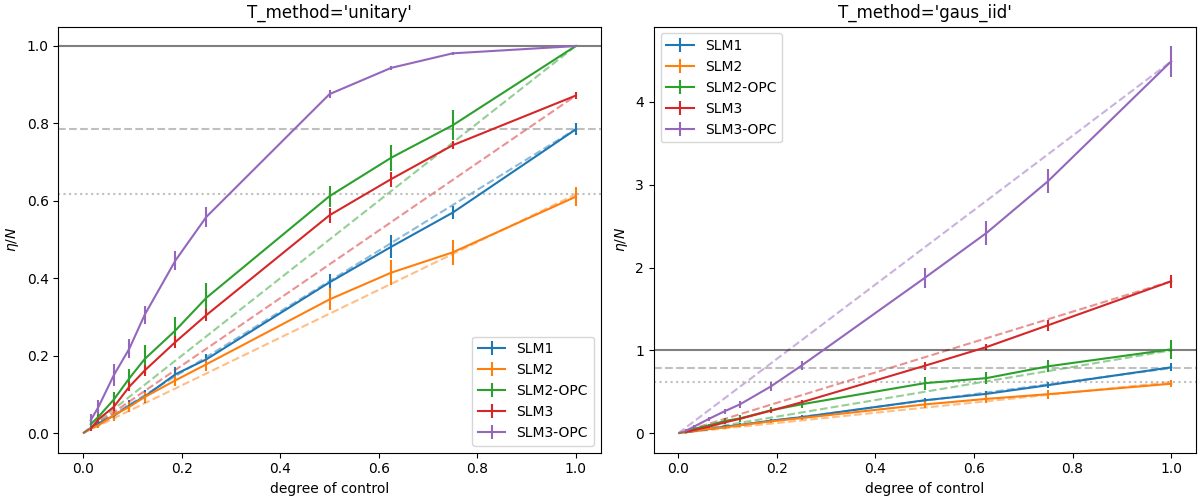

In [39]:
fig3(N_pixs, ress)
# plt.close('all')
# show_N_pix_dependance(N_pixs, ress, which_config='SLM1-only-T',which_optimization='autograd', full_std=False, show_tot_power=True)
# show_N_pix_dependance(N_pixs, ress, which_config='SLM2',which_optimization='autograd', full_std=False, show_tot_power=True)
# show_N_pix_dependance(N_pixs, ress, which_config='SLM2-simple-OPC',which_optimization='autograd', full_std=False, show_tot_power=True)
# show_N_pix_dependance(N_pixs, ress, which_config='SLM3',which_optimization='autograd', full_std=False, show_tot_power=True, show_max_SVDs=False)
# show_N_pix_dependance(N_pixs, ress, which_config='SLM3-same-mode',which_optimization='autograd', full_std=False, show_tot_power=True, show_max_SVDs=False)

# Analytical understanding 

Well, we finally understood that if for instancewe want to look at the first fourier mode after the second hit of the SLM, so the fourier elements of F are simply $1/\sqrt{N}$, and this turns a problem of maximizing a quadratic form: $\sum_{i,j}{t_{ij}s_is_j}$. 

This problems, it turns out, is actually... NP hard! 

See:
* https://en.wikipedia.org/wiki/Quadratically_constrained_quadratic_program
* https://scicomp.stackexchange.com/questions/29764/solvers-for-quadratically-constrained-quadratic-programs-qcqp-with-complex-var

Unless we have some structure to the matrix, say that it is positive semi-definite. In the case of two different diffusers we assume nothing about our problem. In the context of the same diffser so we do have $TT^T$ which is symmetric, but not Hermitian, and not positive semi-definite, so I don't think it helps, and it is indeed NP hard. 


Maybe I should ask Dudu Ponarovsky, he is probably good with such questions 

# SLM1 before and after

In the SLM1 case there is nothing interesting when looking at the same mode, since this is not a symmetric configuration. 

In the SLM1 case there *is* a difference in the contrast between the SLM before and after. If SLM is before we get pi/4 out of a total power of 1. If SLM is after we get pi/4 out of ~1.  

In [67]:
# SLM1 with same mode does not do anything special 
# path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_12_23_09_08_38_qwfs_slm1_slm1_same_mode_N=64_50_tries.npz"
# path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_12_23_11_14_10_qwfs_slm1_slm1_after_N=64_50_tries.npz"
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_12_23_11_30_04_qwfs_slm1_all_configs_N=64_100_tries.npz"
res = QWFSResult(path)

configs = ['SLM1', 'SLM1-after', 'SLM1-same-mode', 'SLM1-only-T', 'SLM1-only-T-after']

i = 0
for config in configs:
    # print(i)
    i += 1 
    I_outs, I_focuses = get_slm1_intensities(res, config=config)
    print(config)
    print(f'focus:     {I_focuses.mean():.3f}+-{I_focuses.std():.3f}')
    print(f'tot power: {I_outs.sum(axis=1).mean():.3f}+-{I_outs.sum(axis=1).std():.3f}')
    print()

SLM1
focus:     0.800+-0.169
tot power: 2.568+-0.364

SLM1-after
focus:     0.812+-0.152
tot power: 1.021+-0.191

SLM1-same-mode
focus:     0.814+-0.153
tot power: 2.615+-0.353

SLM1-only-T
focus:     0.788+-0.107
tot power: 1.746+-0.155

SLM1-only-T-after
focus:     0.778+-0.086
tot power: 0.986+-0.102



# SLM3 same mode
Does not seem to have a special effect

---- SLM3 ----
-- unitary --
L-BFGS-B                  0.827+-0.02
-- gaus_iid --
L-BFGS-B                  1.556+-0.08

---- SLM3-same-mode ----
-- unitary --
L-BFGS-B                  0.999+-0.00
-- gaus_iid --
L-BFGS-B                  3.769+-0.22



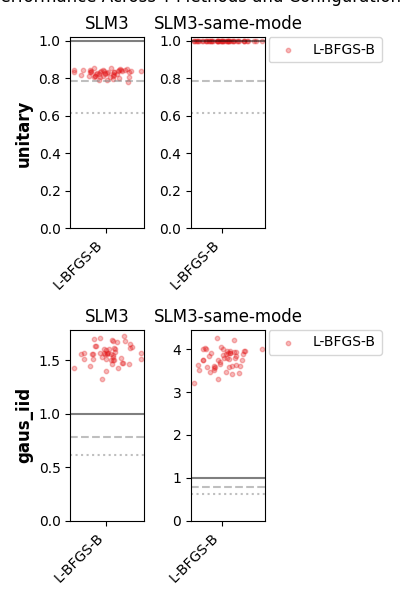

In [77]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_12_12_14_26_08_qwfs_slm3_slm3_same_mode_N=256_50_tries.npz"
res = QWFSResult(path)
res.show_scatterplots()
res.print()

In [78]:
# I_outs, I_focuss = get_slm1_intensities(res, config='SLM3', T_method=T_method, alg='L-BFGS-B')
I_outs, I_focuss = get_slm1_intensities(res, config='SLM3-same-mode', T_method=T_method, alg='L-BFGS-B')
print(f'{res.N_modes=}')
print(f'{I_outs.sum(axis=1).mean()=}')
print(f'{I_outs.sum(axis=1).max()=}')
print(f'{I_focuss.mean()=}')
print(f'{I_focuss.max()=}')

res.N_modes=256
I_outs.sum(axis=1).mean()=4.550641165521182
I_outs.sum(axis=1).max()=5.144319774668913
I_focuss.mean()=3.768571418412942
I_focuss.max()=4.266502690050798


Text(0.5, 1.0, "T_method='unitary', config='SLM3-same-mode'")

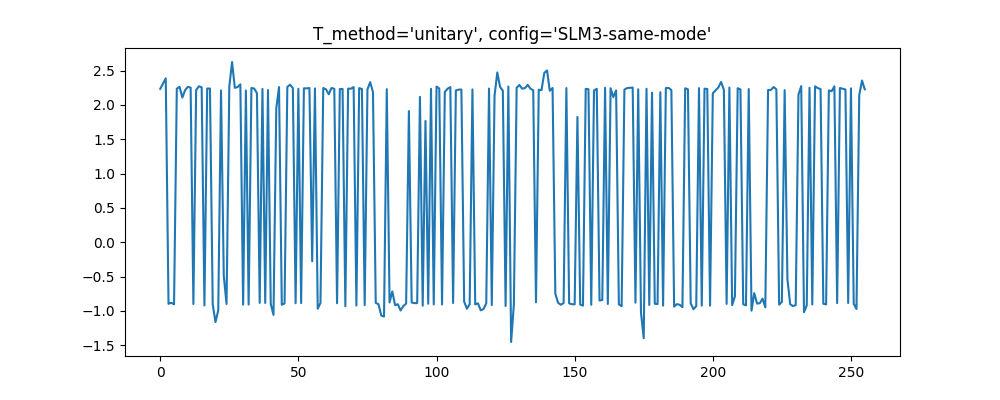

In [67]:
alg = 'L-BFGS-B'
# config = 'SLM3-same-mode'
config = 'SLM3'
T_method = 'unitary'
# T_method = 'gaus_iid'
try_nos = range(res.N_tries)

I_outs = []
I_middles = []
I_focuss = []
E_middles = []
# for try_no in [2]:
for try_no in try_nos:
    alg_ind = np.where(res.algos == alg)[0]
    conf_ind = np.where(res.configs == config)[0]
    T_method_ind = np.where(res.T_methods == T_method)[0]

    T_ind = res.N_T_methods * try_no + T_method_ind
    T = res.Ts[T_ind].squeeze()
    slm_phases = res.best_phases[T_method_ind, conf_ind, try_no, alg_ind].squeeze()
    N = len(slm_phases)

    sim = QWFSSimulation(N=N)
    sim.T = T
    sim.slm_phases = np.exp(1j * slm_phases)
    sim.config = config

    E_middle = sim.T.transpose() @ (sim.slm_phases * sim.v_in)
    I_middle = np.abs(E_middle) ** 2
    I_out = np.abs(sim.propagate()) ** 2
    I_outs.append(I_out)
    I_middles.append(I_middle)
    I_focuss.append(res.results[T_method_ind, conf_ind, try_no, alg_ind].squeeze())
    E_middles.append(E_middle)

I_outs = np.array(I_outs)
I_middles = np.array(I_middles)
I_focuss = np.array(I_focuss)
E_middles = np.array(E_middles)

plt.close('all')
i = np.random.randint(0, res.N_tries)
# i = 12
phases = np.angle(E_middles[i])
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(phases)
ax.set_title(f'{T_method=}, {config=}')

In [42]:
1.97 + 1.15

3.12